In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_crosscorr_matrix,
    plot_averages_with_ci,
    plot_averages_with_ci_plt,
    plot_correlation_heatmap,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_trials("Explore_Data", exclude_problematic=True)

df = df.rename({"rating": "pain_rating", "pupil": "pupil_diameter"})

In [5]:
signals = [
    "temperature",
    "pain_rating",
    "pupil_diameter",
    "eda_tonic",
    "eda_phasic",
    "heart_rate",
    "mouth_open",
]

## Averaged trials over stimulus seeds with confidence intervals

In [6]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)


In [15]:
LABELS = {
    "temperature": "Temperature",
    "pain_rating": "Pain rating",
    "pupil_diameter": "Pupil diameter",
    "heart_rate": "Heart rate",
    "eda_tonic": "Tonic EDA",
    "eda_phasic": "Phasic EDA",
    "cheek_raise": "Cheek raise",
    "mouth_open": "Mouth open",
    "upper_lip_raise": "Upper lip raise",
    "nose_wrinkle": "Nose wrinkle",
    "brow_furrow": "Brow furrow",
}


def plot_single_stimulus_seed(
    averages_with_ci_df: pl.DataFrame,
    stimulus_seed: int,
    signals: list[str],
    alpha: float = 1.0,
    show_ci: bool = True,
) -> plt.Figure:
    """
    Plot averages with confidence intervals for a single stimulus seed.

    Args:
        averages_with_ci_df: DataFrame containing averages and confidence intervals
        stimulus_seed: The stimulus seed to plot
        signals: List of signal names to plot
        alpha: Transparency of the lines (0-1)
        show_ci: Whether to show confidence intervals

    Returns:
        Matplotlib figure
    """
    # Filter data for the specified stimulus seed
    seed_data = averages_with_ci_df.filter(pl.col("stimulus_seed") == stimulus_seed)

    if seed_data.height == 0:
        raise ValueError(f"No data found for stimulus_seed={stimulus_seed}")

    # Create figure
    fig, ax = plt.subplots(figsize=(9, 4))

    # Color palette matching the reference image
    color_map = {
        # "temperature": "#5B9BD5",  # blue
        "temperature": "#000080",  # blue
        "pain_rating": "#FD5030",  # orange
        "pupil_diameter": "#FFC000",  # yellow
        "eda_tonic": "#70AD47",  # green
        "eda_phasic": "#A6A6A6",  # gray
        "heart_rate": "#4BACC6",  # cyan
        "mouth_open": "#9E7BB5",  # purple
    }

    # Plot each signal
    for sig in signals:
        color = color_map.get(sig, plt.cm.tab10(len(signals)))
        signal_label = LABELS.get(sig, sig)

        # Plot the average line
        ax.plot(
            seed_data["time_bin"],
            seed_data[f"avg_{sig}"],
            label=signal_label,
            color=color,
            alpha=alpha,
            linewidth=1.5,
        )

        # Plot confidence interval if requested
        if show_ci:
            ax.fill_between(
                seed_data["time_bin"],
                seed_data[f"ci_lower_{sig}"],
                seed_data[f"ci_upper_{sig}"],
                color=color,
                alpha=0.2,
                linewidth=0,
            )

    # Customize plot
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalized value")
    ax.set_xlim(seed_data["time_bin"].min(), seed_data["time_bin"].max())
    ax.grid(True, alpha=0.3)

    # Place legend below the plot
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        ncol=1,
        framealpha=0.9,
    )

    plt.tight_layout()

    return fig

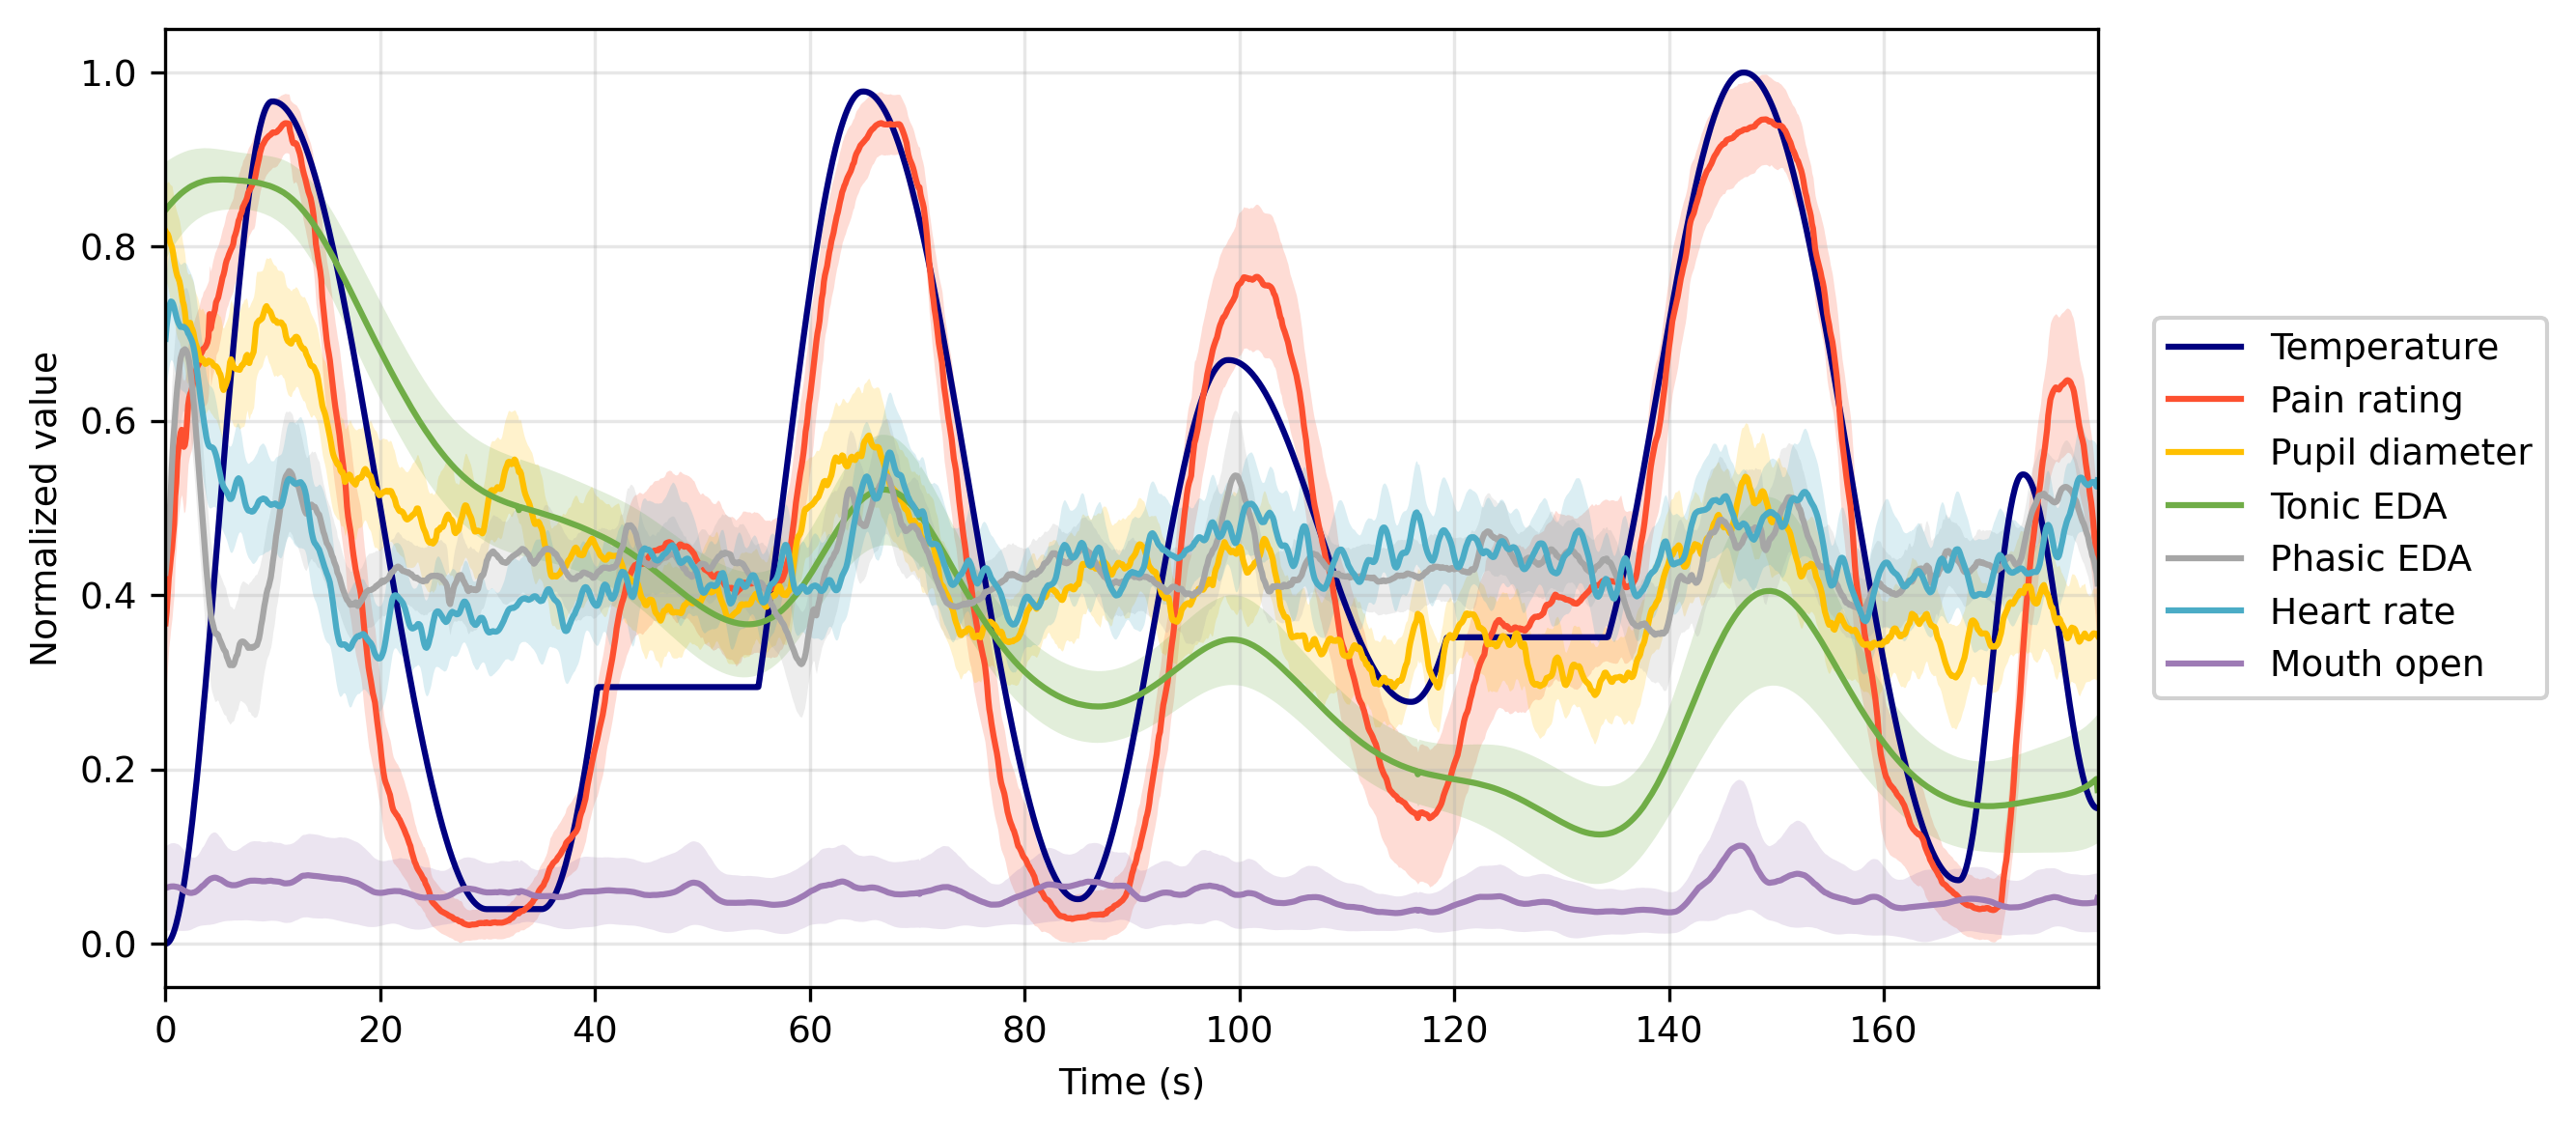

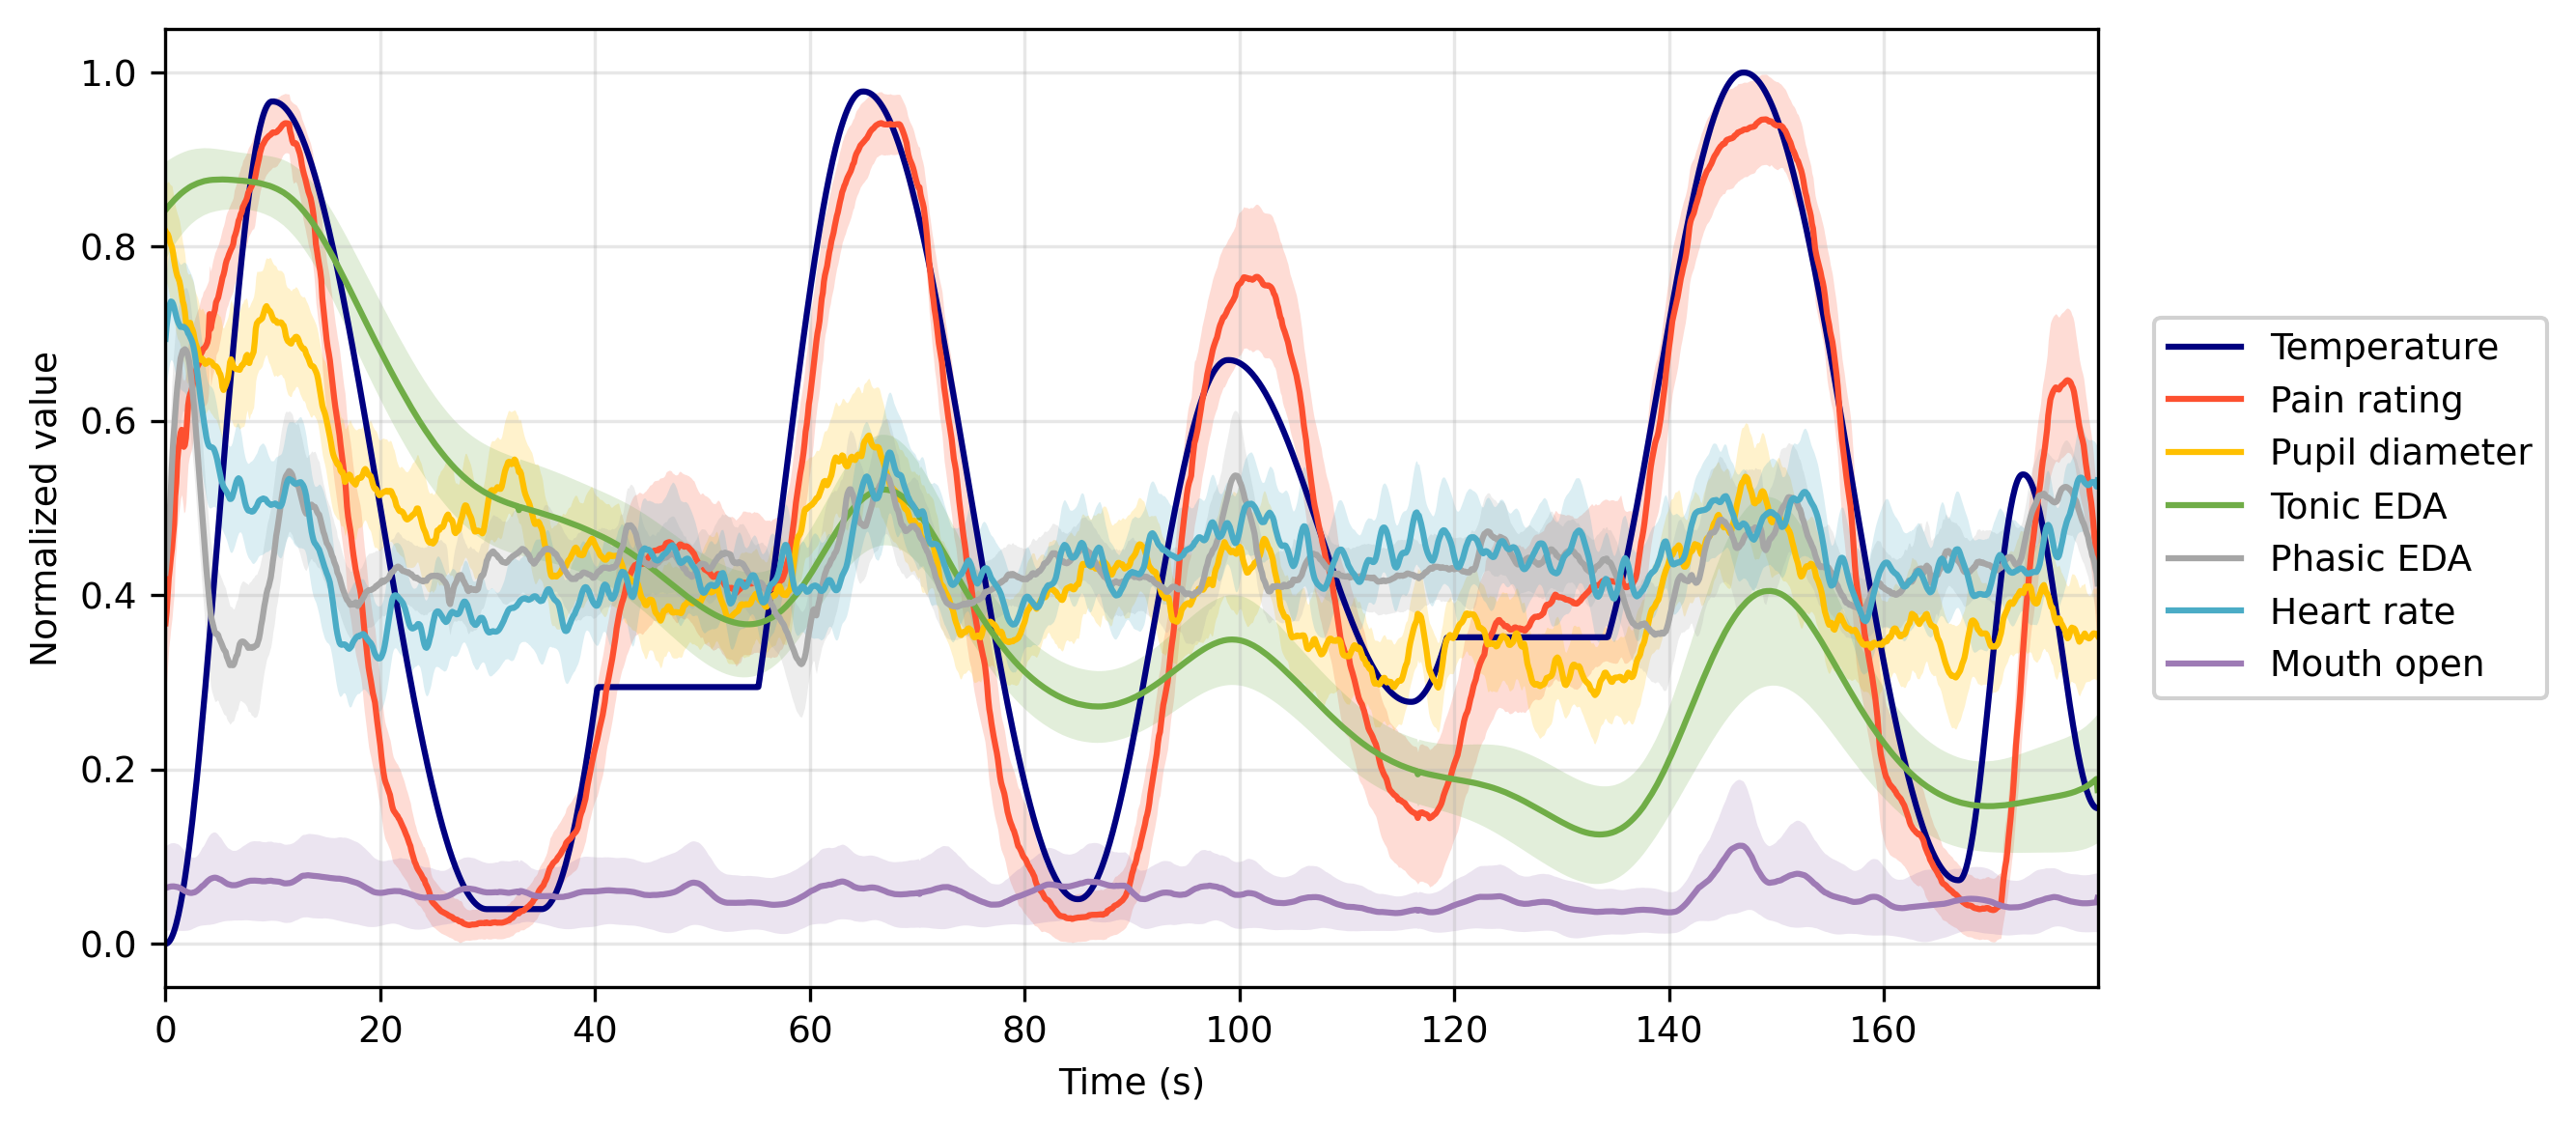

In [16]:
plot_single_stimulus_seed(averges_with_ci, 133, signals)


In [ ]:
plot_averages_with_ci(averges_with_ci, signals)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ec15680c-54c8-452f-8fe2-d3abd0eac01d': {'version…

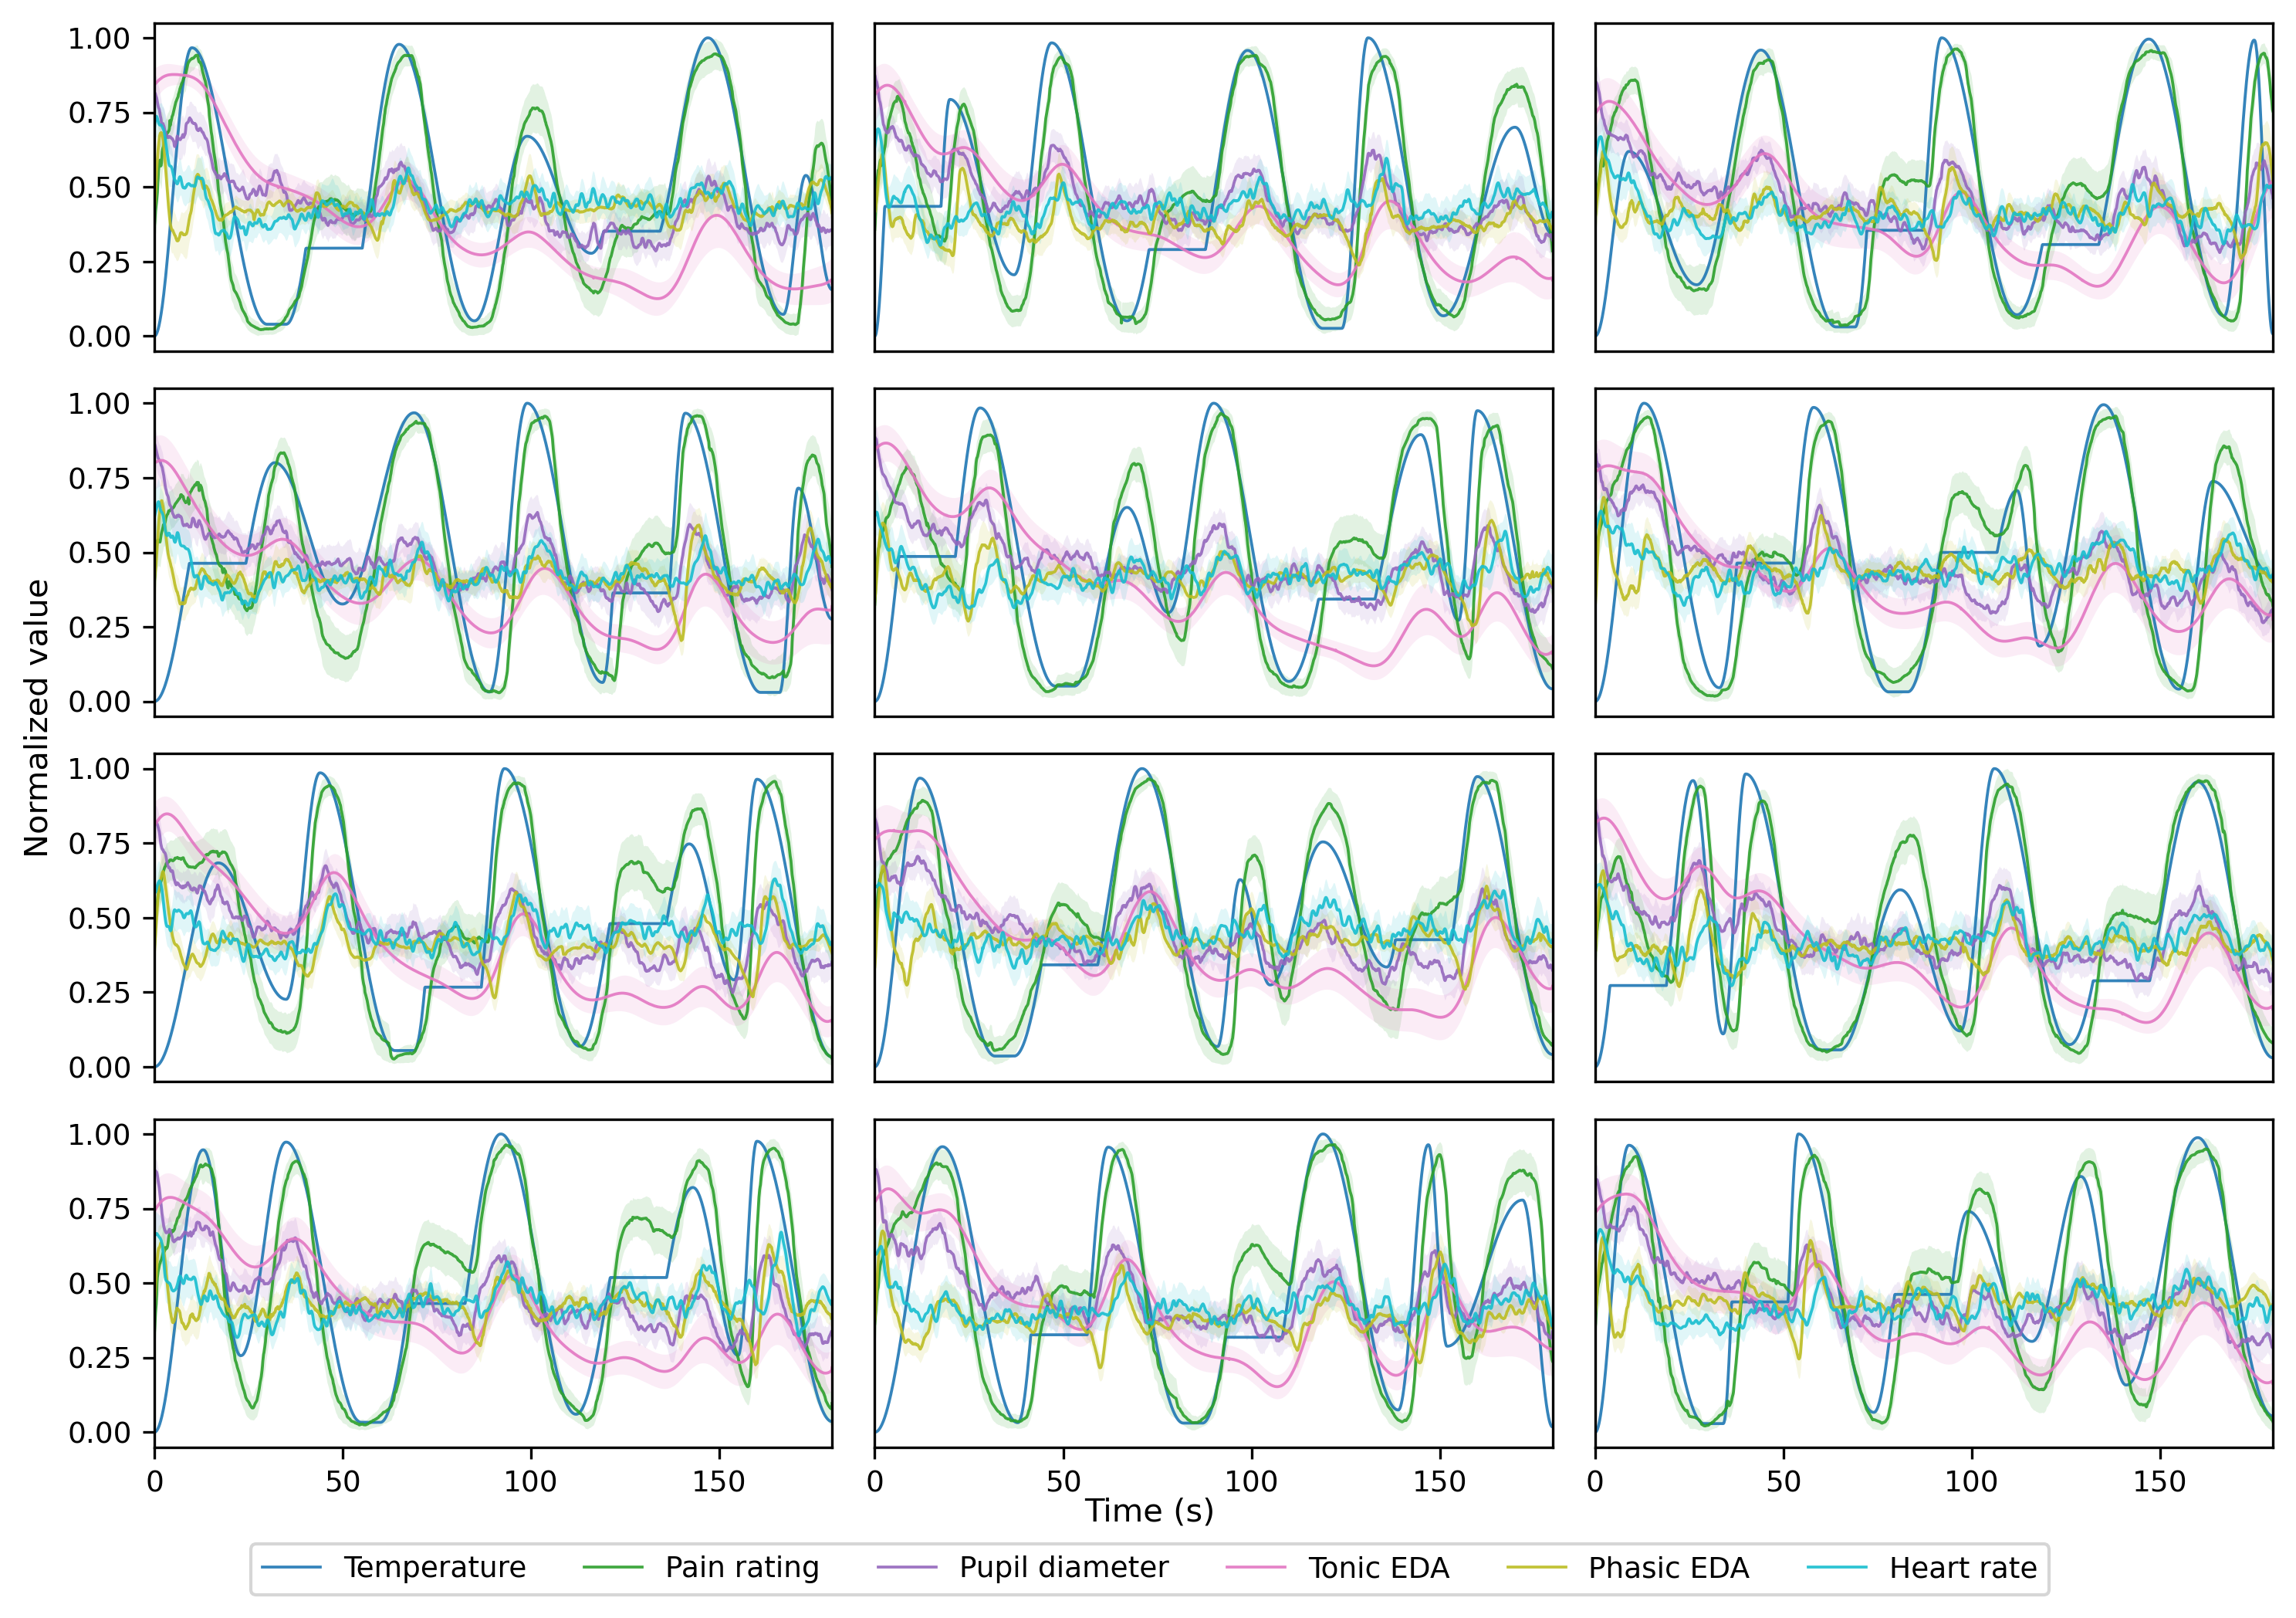

In [8]:
plots = plot_averages_with_ci_plt(averges_with_ci, signals, alpha=0.9)

In [7]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

plots.savefig(FIGURE_DIR / "averages_over_stimulus_seeds.png")

# Correlation matrix

In [15]:
# Remove first 20 seconds
# NOTE: important for the paper
averages = averages.filter(col("time_bin") >= 20)

In [16]:
averages

shape: (19_200, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ stimulus_ ┆ avg_tempe ┆ avg_pain_ ┆ avg_pupil ┆ … ┆ std_eda_p ┆ std_heart ┆ sample_si ┆ time_bin │
│ seed      ┆ rature    ┆ rating    ┆ _diameter ┆   ┆ hasic     ┆ _rate     ┆ ze        ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ f64      │
│ u16       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ u32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 133       ┆ 0.500538  ┆ 0.227467  ┆ 0.515073  ┆ … ┆ 0.122492  ┆ 0.186897  ┆ 37        ┆ 20.0     │
│ 133       ┆ 0.493263  ┆ 0.215004  ┆ 0.516407  ┆ … ┆ 0.123752  ┆ 0.186563  ┆ 37        ┆ 20.1     │
│ 133       ┆ 0.485975  ┆ 0.204909  ┆ 0.517615  ┆ … ┆ 0.122598  ┆ 0.186411  ┆ 37        ┆ 20.2     │
│ 133       ┆ 0.478646  ┆ 0.196032  ┆ 0.518322  ┆ … ┆ 0.121638  ┆ 0.187879  ┆ 37        ┆ 20.3     │
│ 133       ┆ 0.471355  ┆ 0.188876  ┆ 0.518599  ┆ … ┆ 0.121965  ┆ 0.191085  ┆ 37        ┆ 20.4     │
│ 133       ┆ 0.464048  ┆ 0.1846    ┆ 0.519583  ┆ … ┆ 0.122033  ┆ 0.195464  ┆ 37        ┆ 20.5     │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 952       ┆ 0.055794  ┆ 0.045383  ┆ 0.30126   ┆ … ┆ 0.145278  ┆ 0.196821  ┆ 40        ┆ 179.4    │
│ 952       ┆ 0.055265  ┆ 0.042738  ┆ 0.296509  ┆ … ┆ 0.142599  ┆ 0.195075  ┆ 40        ┆ 179.5    │
│ 952       ┆ 0.05485   ┆ 0.041118  ┆ 0.291483  ┆ … ┆ 0.138084  ┆ 0.192876  ┆ 40        ┆ 179.6    │
│ 952       ┆ 0.054551  ┆ 0.040157  ┆ 0.285746  ┆ … ┆ 0.134005  ┆ 0.19018   ┆ 40        ┆ 179.7    │
│ 952       ┆ 0.05437   ┆ 0.039761  ┆ 0.283135  ┆ … ┆ 0.135591  ┆ 0.187936  ┆ 40        ┆ 179.8    │
│ 952       ┆ 0.054299  ┆ 0.036165  ┆ 0.287196  ┆ … ┆ 0.147393  ┆ 0.175262  ┆ 46        ┆ 179.9    │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [17]:
# Reorder signals for correlation matrix
signals = [
    "temperature",
    "pain_rating",
    "pupil_diameter",
    "heart_rate",
    "eda_tonic",
    "eda_phasic",
]


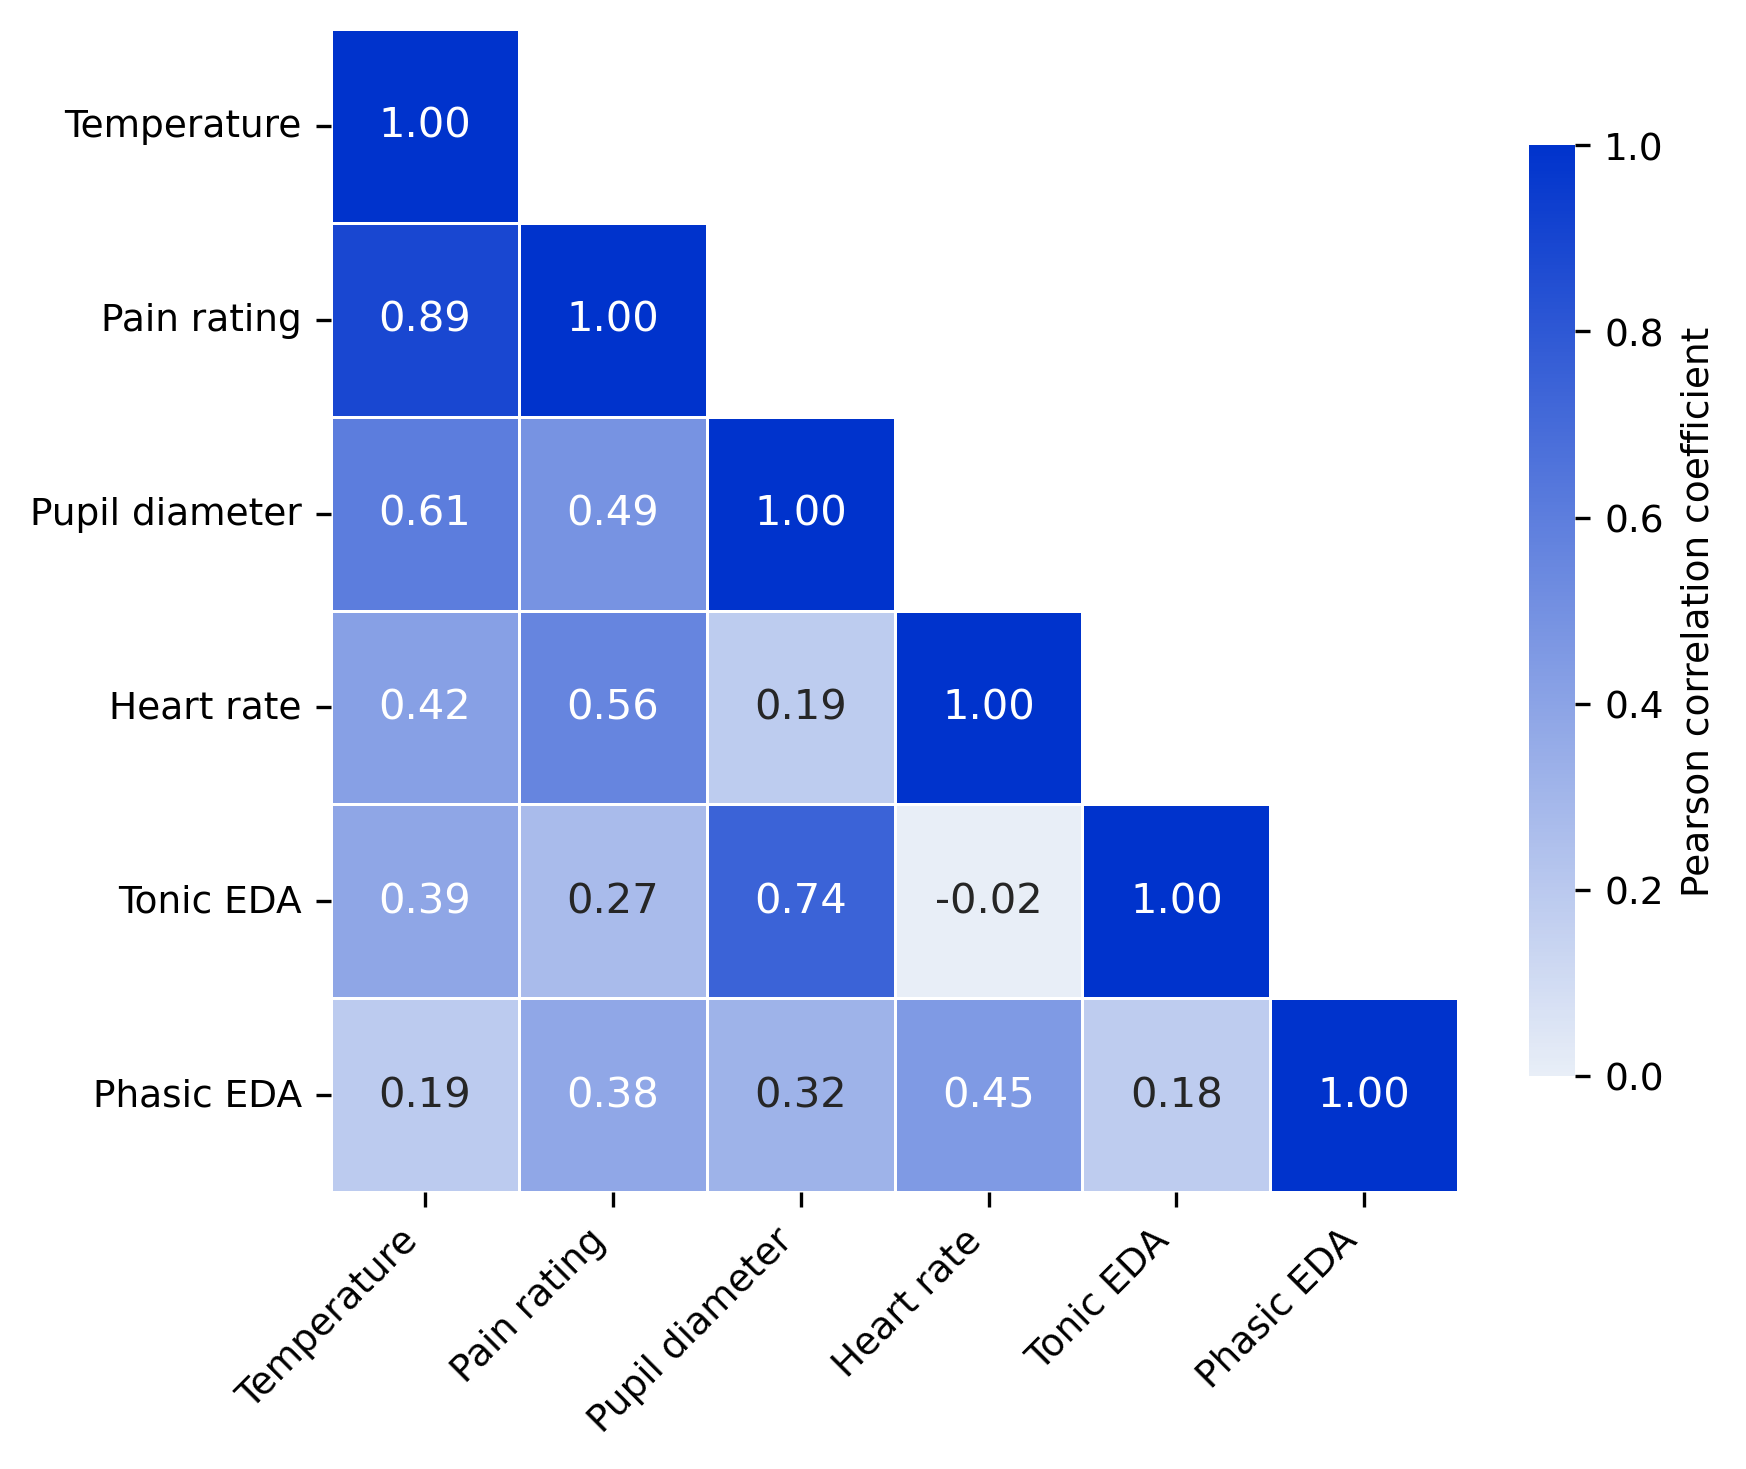

In [18]:
# without first 20 seconds
correlation_heatmap = plot_correlation_heatmap(averages)

In [12]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)

In [19]:
# Sample code for correlations for each stimulus seed with standard deviation
correlations = []
for group in averages.group_by("stimulus_seed"):
    corr = group[1].select(pl.corr("avg_pupil_diameter", "avg_eda_phasic")).item()
    correlations.append(corr)
correlations = np.array(correlations)
correlations.mean().round(2), correlations.std().round(2)


(0.37, 0.05)

## Cross correlation lags of grand means

In [20]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="temperature",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
# cross_corr_results.write_json(FIGURE_DIR / "cross_corr_results.json")
cross_corr_results

shape: (5, 4)
┌──────────────────┬────────────────┬───────────┬──────────┐
│ reference_signal ┆ target_signal  ┆ mean_lag  ┆ std_lag  │
│ ---              ┆ ---            ┆ ---       ┆ ---      │
│ str              ┆ str            ┆ f64       ┆ f64      │
╞══════════════════╪════════════════╪═══════════╪══════════╡
│ temperature      ┆ pupil_diameter ┆ -0.066667 ┆ 0.221108 │
│ temperature      ┆ eda_tonic      ┆ -0.95     ┆ 0.589491 │
│ temperature      ┆ pain_rating    ┆ -1.008333 ┆ 0.335307 │
│ temperature      ┆ heart_rate     ┆ -1.758333 ┆ 1.362264 │
│ temperature      ┆ eda_phasic     ┆ -2.45     ┆ 0.886472 │
└──────────────────┴────────────────┴───────────┴──────────┘

In [15]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="pain_rating",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_rating_results.json")
cross_corr_results

shape: (5, 4)
┌──────────────────┬────────────────┬───────────┬──────────┐
│ reference_signal ┆ target_signal  ┆ mean_lag  ┆ std_lag  │
│ ---              ┆ ---            ┆ ---       ┆ ---      │
│ str              ┆ str            ┆ f64       ┆ f64      │
╞══════════════════╪════════════════╪═══════════╪══════════╡
│ pain_rating      ┆ temperature    ┆ 1.008333  ┆ 0.335307 │
│ pain_rating      ┆ pupil_diameter ┆ 0.608333  ┆ 0.714677 │
│ pain_rating      ┆ eda_tonic      ┆ -0.1      ┆ 0.177951 │
│ pain_rating      ┆ heart_rate     ┆ -0.341667 ┆ 0.526717 │
│ pain_rating      ┆ eda_phasic     ┆ -0.516667 ┆ 0.468745 │
└──────────────────┴────────────────┴───────────┴──────────┘

In [14]:
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)